In [471]:
from pyspark.sql import SparkSession
import requests
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import substring, col, sum, when, lit
import seaborn as sns
import mysql.connector

In [472]:
#create sparksession entry point to apache spark allows to work with dataframes and transformations
spark = SparkSession.builder.getOrCreate()

#read json into rdd using .rdd
branch_rdd = spark.read.json("CDW_SAPP_BRANCH.JSON").rdd
credit_rdd = spark.read.json("CDW_SAPP_CREDIT.JSON").rdd
customer_rdd = spark.read.json("CDW_SAPP_CUSTMER.JSON").rdd

In [473]:
#map applies given function lambda which applies transformations using row
#row represents every element of the rdd 
branch_transformed_rdd = branch_rdd.map(lambda row: (
    #direct moves, no transformations needed
    int(row["BRANCH_CODE"]),
    str(row["BRANCH_NAME"]),
    str(row["BRANCH_STREET"]),
    str(row["BRANCH_CITY"]),
    str(row["BRANCH_STATE"]),
    
    #takes values from BRANCH_ZIP and if null will set row to 99999
    int(row["BRANCH_ZIP"]) if row["BRANCH_ZIP"] is not None else 99999,
    #transforms BRANCH_PHONE to phone number format
    "(" + row["BRANCH_PHONE"][:3] + ")" + row["BRANCH_PHONE"][3:6] + "-" + row["BRANCH_PHONE"][6:],
))      

#transformed rdd is converted dataframe using .toDF
branch_transformed_df = branch_transformed_rdd.toDF(["BRANCH_CODE", "BRANCH_NAME", "BRANCH_STREET", "BRANCH_CITY", "BRANCH_STATE", "BRANCH_ZIP", "BRANCH_PHONE"])

#output the new dataframe
branch_transformed_df.show()

+-----------+------------+-------------------+-----------------+------------+----------+-------------+
|BRANCH_CODE| BRANCH_NAME|      BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|
+-----------+------------+-------------------+-----------------+------------+----------+-------------+
|          1|Example Bank|       Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|
|          2|Example Bank|  Washington Street|          Huntley|          IL|     60142|(123)461-8993|
|          3|Example Bank|      Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|
|          4|Example Bank|   Cleveland Street|       Middleburg|          FL|     32068|(123)466-3064|
|          5|Example Bank|        14th Street|    KingOfPrussia|          PA|     19406|(123)484-9701|
|          7|Example Bank|   Jefferson Street|         Paterson|          NJ|      7501|(123)414-4890|
|          8|Example Bank|           B Street|        Pittsford|         

In [474]:
credit_transformed_rdd = credit_rdd.map(lambda row: (
    str(row["CREDIT_CARD_NO"]),

    #concatenate year month day into TIMEID YYYYMMDD format using zfill on single digit "MONTH" "DAY"
    str(row["YEAR"]) + str(row["MONTH"]).zfill(2) + str(row["DAY"]).zfill(2),

    #direct move no transformations needed
    int(row["CUST_SSN"]),
    int(row["BRANCH_CODE"]),
    str(row["TRANSACTION_TYPE"]),
    float(row["TRANSACTION_VALUE"]),
    int(row["TRANSACTION_ID"])
))


credit_transformed_df = credit_transformed_rdd.toDF(["CREDIT_CARD_NO", "TIMEID", "CUST_SSN", "BRANCH_CODE", "TRANSACTION_TYPE", "TRANSACTION_VALUE", "TRANSACTION_ID"])

credit_transformed_df.show()

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|  CREDIT_CARD_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|
|4210653349028689|20180528|123459988|        164|       Education|             6.89|             6|
|4210653349028689|20180519|123459988|        119|   Entertainment|            43.39|             7|


In [475]:
customer_transformed_rdd = customer_rdd.map(lambda row: (
    int(row["SSN"]),
    # .title() makes it title case
    str(row["FIRST_NAME"]).title(),
    # .lower() makes it lower case
    str(row["MIDDLE_NAME"]).lower(),
    str(row["LAST_NAME"]).title(),
    str(row["CREDIT_CARD_NO"]),
    #concatenate STREET_NAME and APT_NO using + operator
    str(row["STREET_NAME"]) + ", " + str(row["APT_NO"]),
    str(row["CUST_CITY"]),
    str(row["CUST_STATE"]),
    str(row["CUST_COUNTRY"]),
    int(row["CUST_ZIP"]),
    #turn into phone number format, this time phone number is 7 digits +XXX to make it 10 to fit the format
    "(" + str(row["CUST_PHONE"])[:3] + ")" + str(row["CUST_PHONE"])[3:6] + "-" + str(row["CUST_PHONE"])[6:] + "XXX",
    str(row["CUST_EMAIL"]),
    row["LAST_UPDATED"]
))

customer_transformed_df = customer_transformed_rdd.toDF(["SSN", "FIRST_NAME", "MIDDLE_NAME", "LAST_NAME", "CREDIT_CARD_NO","FULL_STREET_ADDRESS", "CUST_CITY", "CUST_STATE", "CUST_COUNTRY","CUST_ZIP", "CUST_PHONE", "CUST_EMAIL", "LAST_UPDATED"])

customer_transformed_df.show()

+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+--------------------+--------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|          CUST_EMAIL|        LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+--------------------+--------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|     Natchez|        MS|United States|   39120|(123)781-8XXX| AHooper@example.com|2018-04-21T12:49:...|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  Redwood Drive, 829|Wethersfield|        CT|United States|    6109|(123)893-3XXX| EHolman@example.com|2018-04-21T12:49:...|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|12th Stre

In [476]:
#write transformed branch into mysql using jdbc
branch_transformed_df.write.format("jdbc").options(
    url="jdbc:mysql://localhost/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_BRANCH",
    user="root",
    password="password"
#use overwrite to prevent redundant data
).mode("overwrite").save()

#read the new table from sql
branch_sql = spark.read.format("jdbc").options(
    url="jdbc:mysql://localhost/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_BRANCH",
    user="root",
    password="password"
#stored contents into branch_sql
).load()

#display sql table contents
branch_sql.show()

+-----------+------------+-------------------+-----------------+------------+----------+-------------+
|BRANCH_CODE| BRANCH_NAME|      BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|
+-----------+------------+-------------------+-----------------+------------+----------+-------------+
|          1|Example Bank|       Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|
|          2|Example Bank|  Washington Street|          Huntley|          IL|     60142|(123)461-8993|
|          3|Example Bank|      Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|
|          4|Example Bank|   Cleveland Street|       Middleburg|          FL|     32068|(123)466-3064|
|          5|Example Bank|        14th Street|    KingOfPrussia|          PA|     19406|(123)484-9701|
|          7|Example Bank|   Jefferson Street|         Paterson|          NJ|      7501|(123)414-4890|
|          8|Example Bank|           B Street|        Pittsford|         

In [477]:
credit_transformed_df.write.format("jdbc").options(
    url="jdbc:mysql://localhost/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_CREDIT_CARD",
    user="root",
    password="password"
).mode("overwrite").save()

credit_sql = spark.read.format("jdbc").options(
    url="jdbc:mysql://localhost/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_CREDIT_CARD",
    user="root",
    password="password"
).load()

credit_sql.show()

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|  CREDIT_CARD_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|
|4210653349028689|20180528|123459988|        164|       Education|             6.89|             6|
|4210653349028689|20180519|123459988|        119|   Entertainment|            43.39|             7|


In [478]:
customer_transformed_df.write.format("jdbc").options(
    url="jdbc:mysql://localhost/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_CUSTOMER",
    user="root",
    password="password"
).mode("overwrite").save()

customer_sql = spark.read.format("jdbc").options(
    url="jdbc:mysql://localhost/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_CUSTOMER",
    user="root",
    password="password"
).load()

customer_sql.show()

+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+--------------------+--------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|          CUST_EMAIL|        LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+--------------------+--------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|     Natchez|        MS|United States|   39120|(123)781-8XXX| AHooper@example.com|2018-04-21T12:49:...|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  Redwood Drive, 829|Wethersfield|        CT|United States|    6109|(123)893-3XXX| EHolman@example.com|2018-04-21T12:49:...|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|12th Stre

In [479]:
def transactions_by_zip_month_year(credit_sql, customer_sql):
    while True:
        #user input zipcode then validated
        zip_code = input("Please enter your zip code. ")
       
        if (len(zip_code) == 5 or len(zip_code) == 4) and zip_code.isdigit():
            break
        else:           
            print("Invalid zip code, please enter your zip code.")

    while True:
        #user input month then validated
        month = input("Please enter the month of the transactions in numeric form: ")
        
        if month.isdigit() and 1 <= int(month) <= 12:
            month = month.zfill(2)
            break
        else:
            print("Invalid month. Please enter a number from 1 to 12 matching your desired month.")

    #parse sliced TIMEID for unique years
    unique_years = [str(row.TIMEID)[0:4] for row in credit_sql.select("TIMEID").distinct().collect()]   

    #Validate user input for the year by accepting inputs that match TIMEID slice
    while True:
        year = input("Please enter the year of your transactions: ")
        if year in unique_years:
            break
        else:
            print("Invalid input. Please enter the year of the transaction.")

    #inner join credit_sql and credit_sql by common column SSN 
    custcred_df = credit_sql.join(customer_sql, credit_sql.CUST_SSN == customer_sql.SSN, 'inner').orderBy(col("CUST_SSN").desc())

    #goes through crustcred_df matching user inputted zip_code month year against CUST_ZIP column and slices of TIMEID
    transactions = custcred_df.filter(
        (custcred_df.CUST_ZIP == zip_code) &
        (substring(custcred_df.TIMEID, 1, 4) == year) &
        (substring(custcred_df.TIMEID, 5, 2) == month)
    ).withColumn("day", substring(custcred_df.TIMEID, 7, 2)).orderBy(col("day").desc())

   
    if transactions.count() == 0:
        print("That information does not match our records.")
    else:
        transactions.show()

transactions_by_zip_month_year(credit_sql, customer_sql)

+----------------+--------+---------+-----------+----------------+-----------------+--------------+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+--------------------+--------------------+---+
|  CREDIT_CARD_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|          CUST_EMAIL|        LAST_UPDATED|day|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+--------------------+--------------------+---+
|4210653384029972|20180827|123455659|         51|            Test|            85.66|         22783|123455659|    Shelly|      mindy|    Quinn|421

In [480]:
def transactions_by_type(credit_sql):
    #retrieve all unique rows of TRANSACTION_TYPE and store it in a list to match against user inputs
    unique_transaction_types = credit_sql.select("TRANSACTION_TYPE").distinct().orderBy("TRANSACTION_TYPE")
    transaction_types_list = [row.TRANSACTION_TYPE.lower() for row in unique_transaction_types.collect()]

    #validates user input against transaction_type list
    while True:
        transaction_type = input("Please enter the transaction type: ").lower()
        if transaction_type in transaction_types_list:
            break
        else:
            print("Invalid transaction type. Please enter a valid option.")

    #goes through credit_sql finding every instance users input matches
    transaction_types = credit_sql.filter(col("TRANSACTION_TYPE").like(transaction_type))

    if transaction_types.count() == 0:
        print("No transactions found for the given type.")
    else:
        total_transactions = transaction_types.count()
        total_value = transaction_types.select(col("TRANSACTION_VALUE")).groupBy().sum().collect()[0][0]

        print("Total transactions of " + transaction_type.title() + ": " + str(total_transactions))
        print("Total transaction value of " + transaction_type.title() + ": " + str(total_value))

transactions_by_type(credit_sql)

Total transactions of Bills: 6861
Total transaction value of Bills: 351405.28000000084


In [481]:
def transactions_by_state(branch_sql):
    #retrieve all unique rows of BRANCH_STATE and store it in a list to match against user inputs
    unique_states = branch_sql.select("BRANCH_STATE").distinct().orderBy("BRANCH_STATE")
    states_list = [row.BRANCH_STATE.lower() for row in unique_states.collect()]
    #validate user input for state
    while True:
        state = input("Please enter the state of the transactions: ").lower()
        if state in states_list:
            break
        else:
            print("Invalid state. Please enter a valid state code.")

    #inner join credit_sql and branch_sql by common column BRANCH_CODE to use matching data
    branchcred_df = credit_sql.join(branch_sql, credit_sql.BRANCH_CODE == branch_sql.BRANCH_CODE, 'inner')
    
    #goes through credit_sql finding every instance users input matches data
    transactions_state = branchcred_df.filter(branch_sql.BRANCH_STATE == state.upper())

    if transactions_state.count() == 0:
        print("No transactions found for branches in the given state.")
    else:
        total_transactions = transactions_state.count()
        total_value = transactions_state.select(sum("TRANSACTION_VALUE")).collect()[0][0]

        print("Number of transactions for branches in  " + state.upper() + ": " + str(total_transactions))
        print("Total transaction value for branches in  " + state.upper() + ": " + str(total_value))

transactions_by_state(branch_sql)

Number of transactions for branches in  NY: 4143
Total transaction value for branches in  NY: 213717.38000000082


In [482]:
def customer_account_details(customer_sql):
    #asks for user input and validates that the input is 4 digits and a number
    while True:
        ssn = input("Please enter the last 4 digits of your SSN: ")
        if ssn.isdigit() and len(ssn) == 4:
            break
        else:
            print("Invalid input. Please enter the last 4 digits of your SSN.")

    #filtering by column "SSN" in customer_sql for last 4 digits and matching it to user input
    account_details = customer_sql.filter(customer_sql.SSN.substr(-4, 4) == ssn)

    if account_details.count() == 0:
        print("No account details found for the given SSN.")
    else:
        account_details.show()

customer_account_details(customer_sql)

+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+--------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|         CUST_EMAIL|        LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+--------------------+
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|12th Street East,...|  Huntley|        IL|United States|   60142|(124)301-8XXX|WDunham@example.com|2018-04-21T12:49:...|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+--------------------+



In [486]:
def modify_account_details(customer_sql):

    while True:
        #user input and validation of ssn
        ssn_last_4 = input("Please enter the last 4 digits of your SSN (or 'q' to exit at anytime): ")
        if ssn_last_4.lower() == "q":
            return
        elif ssn_last_4.isdigit() and len(ssn_last_4) == 4:
            break
        else:
            print("Invalid input. Please enter the last 4 digits of your SSN.")

    #filtered_customer stores values from each row of the customer with the inputted ssn
    filtered_customer = customer_sql.filter(customer_sql.SSN.substr(-4, 4) == ssn_last_4)

    filtered_customer.show()

    if filtered_customer.count() == 0:
        print("No account found for the provided SSN.")
        return
    #asks user if they want to modify code or exit
    while True:
        choice = input("Do you wish to make any changes? (y/n): ")
        if choice.lower() == "q":
            return
        elif choice.lower() == "n":
            return
        elif choice.lower() == "y":
            break
        else:
            print("Invalid choice. Please enter 'y' to continue or 'n' to exit.")

    account_details_columns = filtered_customer.columns

    #removes ssn and last_updated from options user can modify
    account_details_columns.remove("SSN")
    account_details_columns.remove("LAST_UPDATED")
    #use enumerate to create a numbered list using for loop to iterate through each value of account_detail_column
    for i, account_detail_column in enumerate(account_details_columns, start=1):
        print(str(i) + ". " + account_detail_column)

    #user selects from the enumerated options
    selected_option = input("Select the number corresponding to the account detail you want to modify: ")

    if selected_option.lower() == "q":
        return
    #validates input
    while True:
        if selected_option.isdigit() and 1 <= int(selected_option) <= len(account_details_columns):
            break
        else:
            print("Invalid option. Please enter a valid number.")
            selected_option = input("Select the number corresponding to the account detail you want to modify: ")

    if selected_option.lower() == "q":
            return

    selected_column = account_details_columns[int(selected_option)-1]

    #input modification
    new_value = input("Enter new value for " + selected_column)

    if new_value.lower() == "q":
        return

    #validates that the user is entering a value
    while len(new_value) == 0:
        print("Invalid input. Please enter a value.")
        new_value = input("Enter new value for " + selected_column)

        if new_value.lower() == "q":
            return

    #use lit to replace value in selected column with user input
    filtered_customer = filtered_customer.withColumn(selected_column, lit(new_value))

    #displays updated information and asks user if it is correct
    while True:
        filtered_customer.show()
        confirm = input("Is the information correct? (y/n): ")
        if confirm.lower() == "q":
            return
        elif confirm.lower() == "y":
            break
        elif confirm.lower() == "n":
                return
        else:
            print("Invalid choice. Please enter 'y' to exit, 'n' to start over.")

    conn = mysql.connector.connect(user='root', 
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)
    cursor = conn.cursor()

    update_query = f"UPDATE CDW_SAPP_CUSTOMER SET {selected_column} = '{new_value}' WHERE SSN LIKE '%{ssn_last_4}'"

    cursor.execute(update_query)
    conn.commit()
    cursor.close()
    conn.close()

modify_account_details(customer_sql)

+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+----------+-------------------+--------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|CUST_PHONE|         CUST_EMAIL|        LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+----------+-------------------+--------------------+
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|12th Street East,...|  Huntley|        IL|United States|   60142|   1234567|WDunham@example.com|2018-04-21T12:49:...|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+----------+-------------------+--------------------+

1. FIRST_NAME
2. MIDDLE_NAME
3. LAST_NAME
4. CREDIT_CARD_NO
5. FULL_STREET_ADDRESS
6. CUST_CITY
7. CUST_

In [487]:
customer_sql = spark.read.format("jdbc").options(
    url="jdbc:mysql://localhost/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_CUSTOMER",
    user="root",
    password="password"
).load()

customer_sql.show()

+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+--------------------+--------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|          CUST_EMAIL|        LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+--------------------+--------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|     Natchez|        MS|United States|   39120|(123)781-8XXX| AHooper@example.com|2018-04-21T12:49:...|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  Redwood Drive, 829|Wethersfield|        CT|United States|    6109|(123)893-3XXX| EHolman@example.com|2018-04-21T12:49:...|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|12th Stre

In [488]:
def calculate_transaction_sums(credit_sql):
    while True:
        ssn_last_4 = input("Please enter the last 4 digits of your SSN (or 'q' to exit at anytime): ")
        if ssn_last_4.lower() == "q":
            return
        elif ssn_last_4.isdigit() and len(ssn_last_4) == 4:
            break
        else:
            print("Invalid input. Please enter the last 4 digits of your SSN.")

    #gets user input and validates it
    while True:
        month = input("Please enter the month of your transactions in numeric form (1-12): ")
        if ssn_last_4.lower() == "q":
            return
        elif month.isdigit() and 1 <= int(month) <= 12:
            break
        else:
            print("Invalid input. Please enter a numeric value between 1 and 12.")
     
    #collects unique years
    unique_years = [str(row.TIMEID)[0:4] for row in credit_sql.select("TIMEID").distinct().collect()]  

    while True:
        year = input("Please enter the year of your transactions: ")
        if ssn_last_4.lower() == "q":
            return
        elif year in unique_years:
            break
        else:
            print("Invalid input. Please enter a valid year.")

    #stores rows that match the sliced CUST_SSN and sliced TIMEID
    filtered_transactions = credit_sql.filter(
        (credit_sql.CUST_SSN.substr(-4, 4) == ssn_last_4) &
        (substring(credit_sql.TIMEID, 5, 2).cast("integer") == int(month)) &
        (substring(credit_sql.TIMEID, 1, 4).cast("integer") == int(year))
    )

    #displays information regarding the transactions
    filtered_transactions.select("TRANSACTION_ID", "TRANSACTION_TYPE", "TRANSACTION_VALUE").show()

    #takes sum and .first collects the result
    total_transaction_value = filtered_transactions.agg(sum("TRANSACTION_VALUE")).first()[0]
    
    print("Total Transaction Value:", total_transaction_value)


calculate_transaction_sums(credit_sql)

+--------------+----------------+-----------------+
|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|
+--------------+----------------+-----------------+
|         28705|           Bills|            42.36|
|         28707|             Gas|            18.96|
|         28725|            Test|            58.67|
+--------------+----------------+-----------------+

Total Transaction Value: 119.99000000000001


In [489]:
def display_transactions_between_dates(credit_sql):

    #verify ssn
    while True:
        ssn_last_4 = input("Please enter the last 4 digits of your SSN: ")
        if len(ssn_last_4) == 4 and ssn_last_4.isdigit():
            break
        print("Invalid input. Please enter the last 4 digits of your SSN.")
    #user input start date and end date
    while True:
        start_day = input("{Please enter the start day: ")
        start_month = input("Please enter the start month: ")
        start_year = input("Please enter the start year: ")

        end_day = input("Please enter the end day: ")
        end_month = input("Please enter the end month: ")
        end_year = input("Please enter the end year: ")
    #verifies the values are numbers and correct length and zfill for single digit month and day values
        if (start_day.isdigit() and start_month.isdigit() and start_year.isdigit() and end_day.isdigit() and end_month.isdigit() and end_year.isdigit() and
            len(start_day) <= 2 and len(start_month) <= 2 and len(start_year) == 4 and len(end_day) <= 2 and len(end_month) <= 2 and len(end_year) == 4
        ):
            start_day = start_day.zfill(2)
            start_month = start_month.zfill(2)
            end_day = end_day.zfill(2)
            end_month = end_month.zfill(2)
            break
        print("Invalid input. Please enter valid day, month, and year.")

    #takes the day month and year values and formats it into TIMEID's format through concatenation
    start_date_string = start_year + start_month + start_day
    end_date_string = end_year + end_month + end_day

    #stores rows that match ssn and are within start and end date
    filtered_transactions = credit_sql.filter(
        (credit_sql.CUST_SSN.substr(-4, 4) == ssn_last_4) &
        (credit_sql.TIMEID.substr(1, 8) >= start_date_string) &
        (credit_sql.TIMEID.substr(1, 8) <= end_date_string)
    ).orderBy(col("TIMEID").desc())

    #display relevant columns
    filtered_transactions.select("TIMEID", "TRANSACTION_ID", "TRANSACTION_TYPE", "TRANSACTION_VALUE").show()

display_transactions_between_dates(credit_sql)

+--------+--------------+----------------+-----------------+
|  TIMEID|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|
+--------+--------------+----------------+-----------------+
|20180918|         28698|           Bills|            41.43|
|20180915|         28724|       Education|             3.11|
|20180912|         28730|   Entertainment|           100.12|
|20180904|         28713|             Gas|             6.77|
|20180819|         28710|            Test|              5.3|
|20180805|         28716|             Gas|            41.86|
|20180719|         28717|      Healthcare|            63.84|
|20180711|         28706|   Entertainment|            49.49|
|20180711|         28718|   Entertainment|             94.5|
|20180609|         28720|           Bills|            77.61|
|20180509|         28719|   Entertainment|            43.84|
|20180426|         28715|            Test|            85.73|
|20180419|         28726|            Test|            11.92|
|20180415|         28729

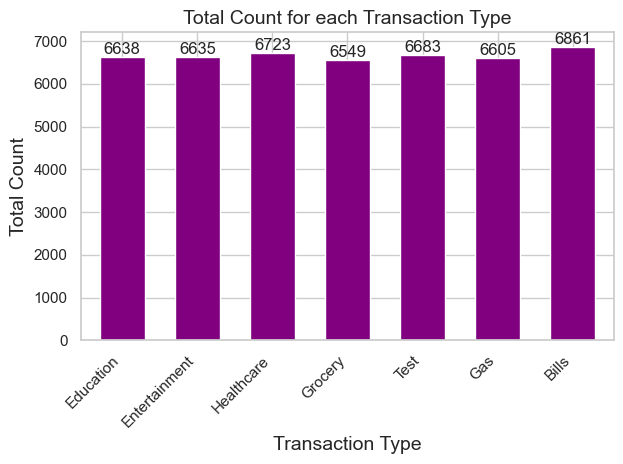

In [490]:
sns.set(style="whitegrid")

transaction_count = credit_sql.groupby("TRANSACTION_TYPE").count()
transaction_count_pd = transaction_count.toPandas()
transaction_count_pd.plot(kind="bar", x="TRANSACTION_TYPE", y="count", legend=False, color="purple", width=0.6)

plt.title("Total Count for each Transaction Type", fontsize=14)
plt.xlabel("Transaction Type", fontsize=14)
plt.ylabel("Total Count", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

for i, value in enumerate(transaction_count_pd["count"]):
    plt.text(i, value, str(value), ha="center", va="bottom")

plt.show()

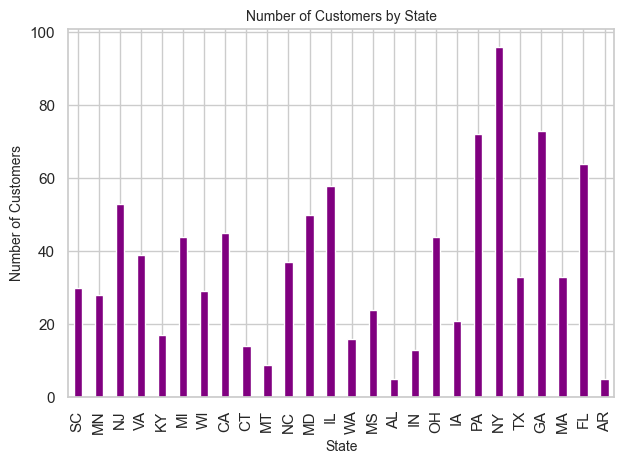

In [499]:
sns.set(style="whitegrid")

state_counts = customer_sql.groupby("CUST_STATE").count()
state_counts_pd = state_counts.toPandas()
state_counts_pd.plot(kind="bar", x="CUST_STATE", y="count", color="purple", legend=False, width=0.4)

plt.title("Number of Customers by State", fontsize=10)
plt.xlabel("State", fontsize=10)
plt.ylabel("Number of Customers", fontsize=10)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

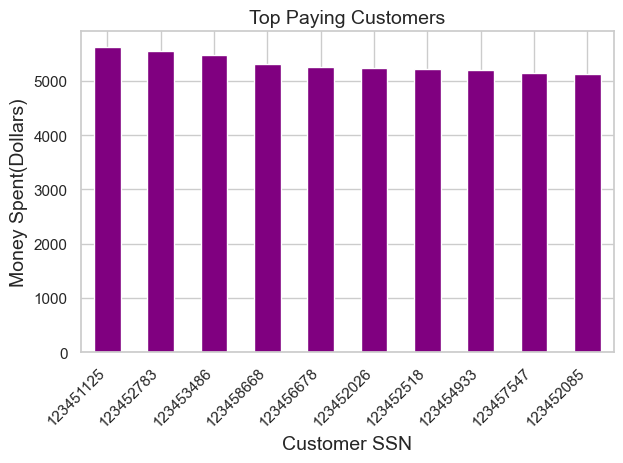

In [492]:
sns.set(style="whitegrid")

customer_transaction_sum = credit_sql.groupby("CUST_SSN").agg(sum("TRANSACTION_VALUE").alias("TRANSACTION_VALUE"))
customer_transaction_sum = customer_transaction_sum.toPandas()
customer_transaction_sum = customer_transaction_sum.sort_values("TRANSACTION_VALUE", ascending=False)
top_10_customers = customer_transaction_sum.head(10)
top_10_customers.plot(kind="bar", x="CUST_SSN", y="TRANSACTION_VALUE", legend=False, color="purple")

plt.title("Top Paying Customers", fontsize=14)
plt.xlabel("Customer SSN", fontsize=14)
plt.ylabel("Money Spent(Dollars)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [493]:
api_url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"

response = requests.get(api_url)

status_code = response.status_code
print("Status Code:", status_code)

loandata_df = spark.read.json(spark.sparkContext.parallelize([response.text]))

loandata_df.write.format("jdbc").options(
    url="jdbc:mysql://localhost:3306/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_loan_application",
    user="root",
    password="password"
).mode("overwrite").save()

loandata_sql = spark.read.format("jdbc").options(
    url="jdbc:mysql://localhost:3306/creditcard_capstone",
    driver="com.mysql.jdbc.Driver",
    dbtable="CDW_SAPP_loan_application",
    user="root",
    password="password"
).load()

loandata_sql.show()

Status Code: 200
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urba

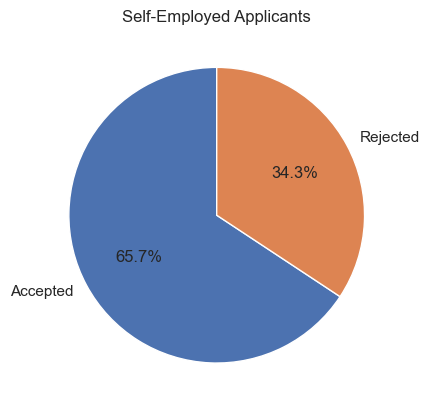

In [494]:
#filter the loan data by taking the Yes values from the Self_Employed columns
self_employed_applications = loandata_sql.filter(loandata_sql["Self_Employed"] == "Yes")
total_self_employed = self_employed_applications.count()
approved_self_employed = self_employed_applications.filter(self_employed_applications["Application_Status"] == "Y").count()
approval_percentage = (approved_self_employed / total_self_employed) * 100
self_employed_df = pd.DataFrame({'Percentage': [approval_percentage, 100 - approval_percentage]}, index=['Accepted', 'Rejected'])
self_employed_df.plot(kind='pie', y = 'Percentage',autopct='%1.1f%%', startangle=90, legend=False)

plt.title('Self-Employed Applicants')
plt.ylabel('')

plt.show()

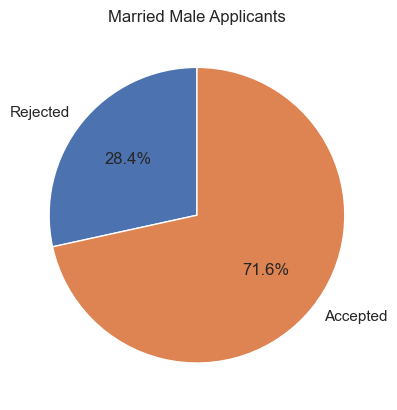

In [495]:
married_male_applicants = loandata_sql.filter((loandata_sql.Married == "Yes") & (loandata_sql.Gender == "Male"))
rejected_applications = married_male_applicants.filter(loandata_sql.Application_Status == "N").count()
total_married_applicants = married_male_applicants.count()
percentage_rejection = (rejected_applications / total_married_applicants) * 100
married_df = pd.DataFrame({'Percentage': [percentage_rejection, 100 - percentage_rejection]}, index=['Rejected', 'Accepted'])
married_df.plot(kind='pie', y='Percentage', autopct='%1.1f%%', startangle=90, legend=False)

plt.title('Married Male Applicants')

plt.ylabel('')
plt.show()

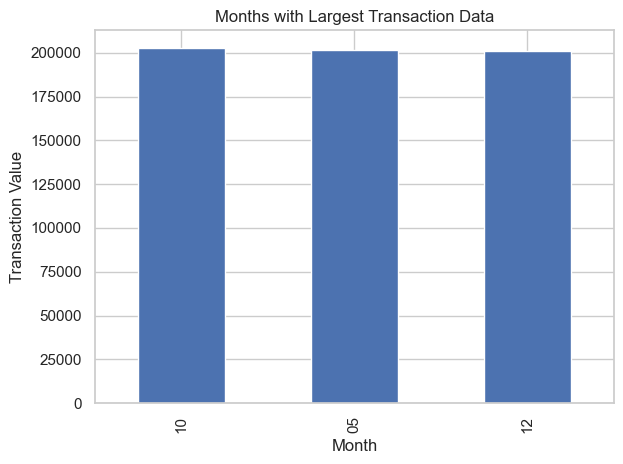

In [496]:
credit_sql = credit_sql.withColumn("month", substring(credit_sql.TIMEID, 5, 2))
transaction_sum_by_month = credit_sql.groupby("month").agg(sum("transaction_value").alias("total_transaction_value"))
sorted_data = transaction_sum_by_month.sort("total_transaction_value", ascending=False)
top_three_months = sorted_data.head(3)
top_three_months_data = [(row.month, row.total_transaction_value) for row in top_three_months]
top_three_months_pd = pd.DataFrame(top_three_months_data, columns=["month", "total_transaction_value"])
top_three_months_pd.plot(kind="bar", x="month", y="total_transaction_value", legend=False)

plt.title("Months with Largest Transaction Data")
plt.xlabel("Month")
plt.ylabel("Transaction Value")
plt.tight_layout()

plt.show()

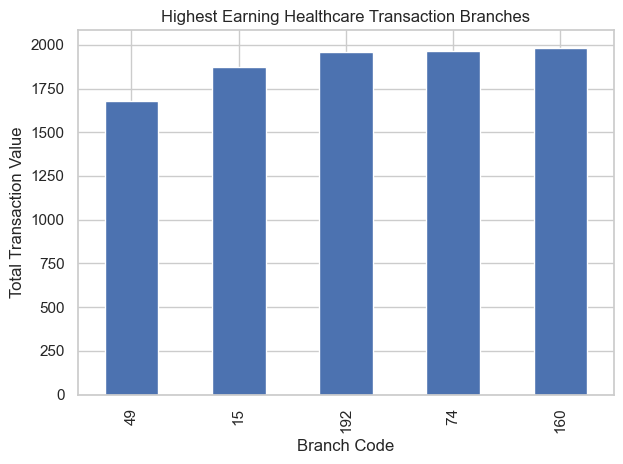

In [497]:
credit_sql = credit_sql.withColumn("month", substring(credit_sql.TIMEID, 5, 2))
healthcare_transactions = credit_sql.filter(credit_sql.TRANSACTION_TYPE.like("Healthcare"))
branch_healthcare_total = healthcare_transactions.groupby("BRANCH_CODE").agg(sum("TRANSACTION_VALUE").alias("total_transaction_value"))
top_5_branches = branch_healthcare_total.orderBy(("total_transaction_value")).head(5)
top_5_df = pd.DataFrame(top_5_branches, columns=["BRANCH_CODE", "total_transaction_value"])
top_5_df.plot(kind="bar", x="BRANCH_CODE", y="total_transaction_value", legend=False)

plt.title("Highest Earning Healthcare Transaction Branches")
plt.xlabel("Branch Code")
plt.ylabel("Total Transaction Value")
plt.tight_layout()

plt.show()